In [32]:
import numpy as np
import pandas as pd
import math

#Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_validate, GridSearchCV

#Feature engineering, pipeline
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import OneHotEncoder, CountFrequencyEncoder, OrdinalEncoder, RareLabelEncoder, MeanEncoder
from feature_engine import imputation as mdi
from feature_engine.discretisation import EqualFrequencyDiscretiser

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Explore The Datasets

In [33]:
data_test = pd.read_csv('z_test.csv')

In [34]:
data_train = pd.read_csv('z_train.csv')

In [35]:
data_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,21651,city_176,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1,24,1.0


In [36]:
data_train.shape

(15326, 14)

In [37]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15326 entries, 0 to 15325
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             15326 non-null  int64  
 1   city                    15326 non-null  object 
 2   city_development_index  15326 non-null  float64
 3   gender                  11725 non-null  object 
 4   relevent_experience     15326 non-null  object 
 5   enrolled_university     15024 non-null  object 
 6   education_level         14957 non-null  object 
 7   major_discipline        13089 non-null  object 
 8   experience              15276 non-null  object 
 9   company_size            10592 non-null  object 
 10  company_type            10435 non-null  object 
 11  last_new_job            14987 non-null  object 
 12  training_hours          15326 non-null  int64  
 13  target                  15326 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [38]:
data_train.describe()

,enrollee_id,city_development_index,training_hours,target
count,15326.000000,15326.000000,15326.000000,15326.000000
mean,16838.278807,0.829929,65.279068,0.249511
std,9625.018286,0.122668,60.079482,0.432744
min,1.000000,0.448000,1.000000,0.000000
25%,8482.250000,0.743000,23.000000,0.000000
50%,16977.000000,0.910000,47.000000,0.000000
75%,25144.000000,0.920000,89.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [39]:
data_train.target.value_counts()

0.0    11502
1.0     3824
Name: target, dtype: int64

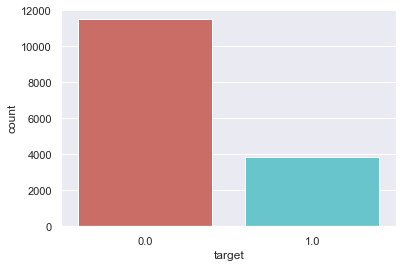

<Figure size 432x288 with 0 Axes>

In [40]:
sns.countplot(x='target', data=data_train, palette='hls')
plt.show()
plt.savefig('count_plot');

In [41]:
count_no_target = len(data_train[data_train['target']==0.0])
count_target = len(data_train[data_train['target']==1.0])
pct_no_target = count_no_target/(count_target+count_no_target)
pct_target = count_target/(count_target+count_no_target)
print(pct_no_target, pct_target)

0.7504893644786637 0.2495106355213363


In [42]:
for var in data_train.columns:
  if data_train[var].isnull().sum() > 0:
    print(var, data_train[var].isnull().mean())

gender 0.23496019835573534
enrolled_university 0.019705076340858673
education_level 0.02407673235025447
major_discipline 0.14596111183609553
experience 0.003262429857758058
company_size 0.3088868589325329
company_type 0.31913088868589323
last_new_job 0.022119274435599634


In [43]:
categorical = [col for col in data_train.columns if data_train[col].dtype == 'object']
len(categorical)

10

In [44]:
data_train[categorical].head()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
0,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1
1,city_40,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4
2,city_21,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never
3,city_115,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never
4,city_176,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1


In [45]:
numerical = [col for col in data_train.columns if data_train[col].dtype != 'object']
len(numerical)

4

In [46]:
corr_matrix = data_train[numerical].corr()

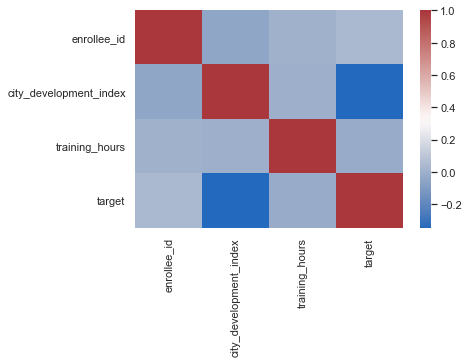

In [47]:
sns.heatmap(corr_matrix, cmap='vlag');

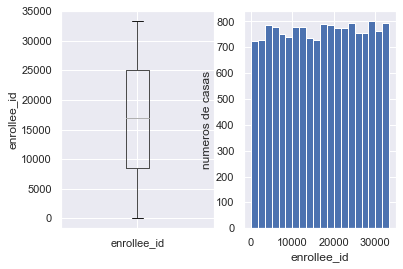

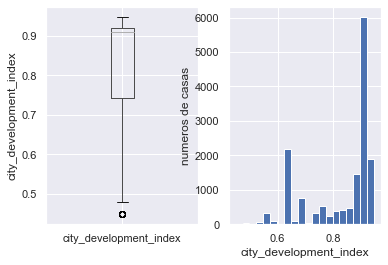

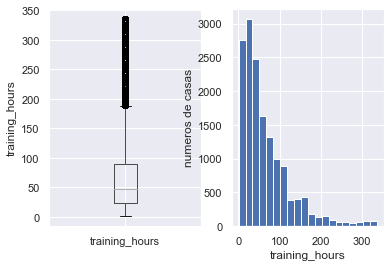

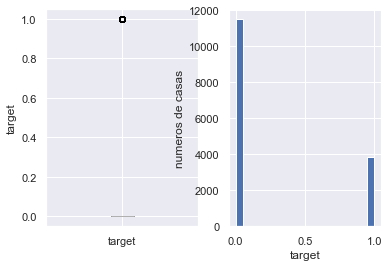

In [48]:
for var in numerical:
  plt.figure(figsize=(6,4))
  plt.subplot(1,2,1)
  fig = data_train.boxplot(column=var)
  fig.set_ylabel(var)

  plt.subplot(1,2,2)
  fig = data_train[var].hist(bins=20)
  fig.set_ylabel('numeros de casas')
  fig.set_xlabel(var)

  plt.show()

Text(0, 0.5, 'Número de categorias diferentes')

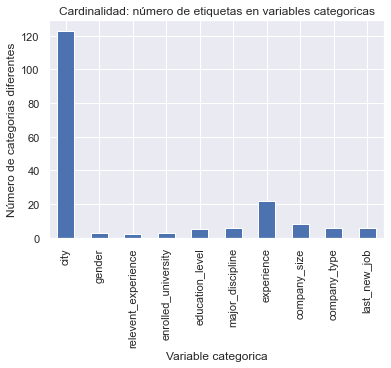

In [49]:
data_train[categorical].nunique().plot.bar()
plt.title('Cardinalidad: número de etiquetas en variables categoricas')
plt.xlabel('Variable categorica')
plt.ylabel('Número de categorias diferentes')

In [50]:
for var in categorical:
    print(var, data_train[var].unique())

city ['city_103' 'city_40' 'city_21' 'city_115' 'city_176' 'city_160' 'city_46'
 'city_61' 'city_114' 'city_159' 'city_102' 'city_67' 'city_100' 'city_16'
 'city_71' 'city_104' 'city_64' 'city_101' 'city_105' 'city_73' 'city_162'
 'city_75' 'city_41' 'city_11' 'city_93' 'city_90' 'city_13' 'city_36'
 'city_20' 'city_57' 'city_152' 'city_19' 'city_65' 'city_173' 'city_136'
 'city_98' 'city_50' 'city_82' 'city_157' 'city_150' 'city_175' 'city_94'
 'city_28' 'city_83' 'city_59' 'city_165' 'city_145' 'city_142' 'city_138'
 'city_12' 'city_37' 'city_116' 'city_23' 'city_99' 'city_149' 'city_10'
 'city_80' 'city_70' 'city_158' 'city_123' 'city_7' 'city_72' 'city_106'
 'city_78' 'city_45' 'city_109' 'city_24' 'city_43' 'city_89' 'city_134'
 'city_144' 'city_91' 'city_146' 'city_133' 'city_126' 'city_9' 'city_128'
 'city_167' 'city_27' 'city_84' 'city_54' 'city_97' 'city_39' 'city_79'
 'city_76' 'city_74' 'city_81' 'city_131' 'city_44' 'city_117' 'city_155'
 'city_26' 'city_118' 'city_143' 'ci

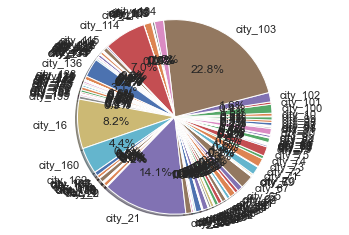

In [51]:
#city

labels = data_train['city'].astype('category').cat.categories.tolist()
counts = data_train['city'].value_counts()
sizes = [counts[var] for var in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()

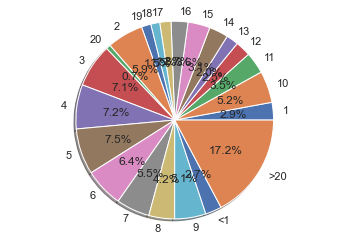

In [52]:
#experience

labels = data_train['experience'].astype('category').cat.categories.tolist()
counts = data_train['experience'].value_counts()
sizes = [counts[var] for var in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()

Handle Missing values

In [53]:
# Obtener cantidad y porcentaje de valores nulos
nulls_train = data_train.isnull().sum().sort_values(ascending = False).reset_index()
nulls_train.columns = ['features','missing_num']
nulls_train['missing_percentage'] = nulls_train['missing_num']/data_train.shape[0]*100
nulls_train['missing_percentage'] = nulls_train['missing_percentage'].round(1)

#Contar valores únicos
for feature in nulls_train['features']:
    nulls_train.loc[(nulls_train['features'] == feature), 'unique_values'] = len(data_train[feature].unique())
nulls_train['unique_values'] = nulls_train['unique_values'].astype(int)

nulls_train

,features,missing_num,missing_percentage,unique_values
0,company_type,4891,31.9,7
1,company_size,4734,30.9,9
2,gender,3601,23.5,4
3,major_discipline,2237,14.6,7
4,education_level,369,2.4,6
5,last_new_job,339,2.2,7
6,enrolled_university,302,2.0,4
7,experience,50,0.3,23
8,enrollee_id,0,0.0,15326
9,city,0,0.0,123


In [54]:
#company_type y company_size tienen más del 30% de nulos, vamos a eliminarlas
data_train_clean = data_train.drop(['company_type', 'company_size'], axis=1)
data_train_clean.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,never,52,1.0
4,21651,city_176,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,1,24,1.0


In [55]:
# Obtener cantidad y porcentaje de valores nulos
nulls_train = data_train_clean.isnull().sum().sort_values(ascending = False).reset_index()
nulls_train.columns = ['features','missing_num']
nulls_train['missing_percentage'] = nulls_train['missing_num']/data_train_clean.shape[0]*100
nulls_train['missing_percentage'] = nulls_train['missing_percentage'].round(1)

nulls_train

,features,missing_num,missing_percentage
0,gender,3601,23.5
1,major_discipline,2237,14.6
2,education_level,369,2.4
3,last_new_job,339,2.2
4,enrolled_university,302,2.0
5,experience,50,0.3
6,enrollee_id,0,0.0
7,city,0,0.0
8,city_development_index,0,0.0
9,relevent_experience,0,0.0


In [56]:
#dropeo las filas de los features que aun tienen nulos:
data_train_clean = data_train_clean.drop(data_train_clean[data_train_clean['gender'].isnull()].index, axis = 0)
data_train_clean = data_train_clean.drop(data_train_clean[data_train_clean['major_discipline'].isnull()].index, axis = 0)
data_train_clean = data_train_clean.drop(data_train_clean[data_train_clean['education_level'].isnull()].index, axis = 0)
data_train_clean = data_train_clean.drop(data_train_clean[data_train_clean['last_new_job'].isnull()].index, axis = 0)
data_train_clean = data_train_clean.drop(data_train_clean[data_train_clean['enrolled_university'].isnull()].index, axis = 0)
data_train_clean = data_train_clean.drop(data_train_clean[data_train_clean['experience'].isnull()].index, axis = 0)

In [57]:
data_train_clean.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [58]:
data_train_clean.shape

(9995, 12)

In [59]:
# export to CSV file
data_train_clean.to_csv('data_train_clean.csv', index=False)